# 城市街景分割数据集下使用对抗网络Pix2Pix根据掩码生成街景

作者信息：[Liyulingyue](https://github.com/Liyulingyue)

更新日期：2022 年 11 月 18 日

## 1. 简要介绍
### 关于城市街景分割数据集下使用对抗网络Pix2Pix根据掩码生成街景
本项目的目标是，根据分割的伪色彩图生成对应的街道场景。

### 关于GAN
简单来说，可以将GAN看作是一种框架，这个框架提供了一种不需要标签即可进行训练的方法。稍微具体一点来说，有一个生成任务，需要生成一组和训练集相同分布的数据，可以按照以下步骤和逻辑训练生成模型：
1. 定义生成模型G，input是一组随机数，output是生成的数据
2. 定义鉴别模型D，input是一组数据，output是这组数据是否是被生成的
3. 将已有数据作为正样本，将生成的数据作为负样本，训练二分类D
4. 将生成数据输入D，将D的输出和正标签求loss，以此loss更新G
5. 重复3和4直至收敛

### 关于Pix2Pix
相比于纯粹的生成，Pix2Pix更多的聚焦于风格迁移，简单来说，就是保持数据的整体形状等信息不变。以绘画为例，Pix2Pix做到的事情类似于一个画手，用素描的方式临摹了梵高的油画。因此，Pix2Pix使用的网络为Unet，也可以替换为其他的基于像素的网络。

### 关于Paddle的梯度反馈
- 目前Paddle的梯度反馈是自动累加模式，所以可以多个batch，或者多个模块的loss单独进行backword
- 通过[Tensor].detach()的方式可以截断梯度传播

### 致谢
本文参考以下项目
- [一文搞懂GAN的风格迁移之Pix2Pix](https://aistudio.baidu.com/aistudio/projectdetail/1119048)
- [Pixel2Pixel：人像卡通化](https://aistudio.baidu.com/aistudio/projectdetail/1813349)

**什么？上面没看懂？不重要！往下看就行了！锐利的loss！锐利的更新！永远的两步走！**

## 2. 环境设置
导入包，主要包括paddle和一些画图辅助，如plt





In [1]:
import os
import random
import paddle 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cv2

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


## 3. 数据集
首先，准备数据集，这里我直接下载paddleseg准备好的数据集。

In [ ]:
! wget https://paddleseg.bj.bcebos.com/dataset/cityscapes.tar
! tar -xf cityscapes.tar

查看图片内容

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


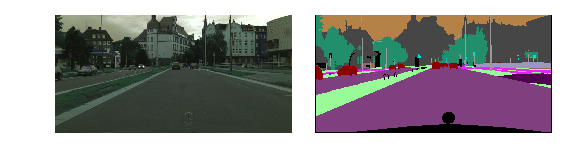

In [2]:
plt.subplot(1, 2, 1)
img = cv2.imread('cityscapes/leftImg8bit/train/aachen/aachen_000001_000019_leftImg8bit.png')
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 2, 2)
img = cv2.imread('cityscapes/gtFine/train/aachen/aachen_000001_000019_gtFine_color.png')
plt.imshow(img)
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.subplots_adjust(wspace=0.1, hspace=0.1)

依赖于cityscapes/train.list，构造一个数据读取器

In [3]:
import paddle
import os

class MyDateset(paddle.io.Dataset):
    def __init__(self, root_dir = 'cityscapes', txt_dir = 'cityscapes/train.list'):
        super(MyDateset, self).__init__()

        self.root_dir = root_dir
        with open(txt_dir,'r') as f:
            self.file_list = f.readlines()

    def __getitem__(self, index):
        file_dir = self.file_list[index][:-1]
        img_dir,mask_dir = file_dir.split(' ')
        mask_dir = mask_dir.replace('_labelTrainIds.png','_color.png')

        img = cv2.imread(os.path.join(self.root_dir,img_dir))
        img = cv2.resize(img, (512, 256)) # （宽，高）
        img = img/255
        img = img.transpose([2,0,1])
        img = paddle.to_tensor(img).astype('float32')

        mask = cv2.imread(os.path.join(self.root_dir,mask_dir))
        mask = cv2.resize(mask, (512, 256)) # （宽，高）
        mask = mask/255
        mask = mask.transpose([2,0,1])
        mask = paddle.to_tensor(mask).astype('float32')

        return img, mask

    def __len__(self):
        return len(self.file_list)

if 1:
    dataset=MyDateset()

    dataloader = paddle.io.DataLoader(
        dataset,
        batch_size=16,
        shuffle=True,
        drop_last=False)

    for step, data in enumerate(dataloader):
        img, mask = data
        print(step, img.shape, mask.shape)
        break

W1122 07:53:33.694149   329 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 11.2
W1122 07:53:33.697855   329 gpu_resources.cc:91] device: 0, cuDNN Version: 8.2.


0 [16, 3, 256, 512] [16, 3, 256, 512]


## 4. 模型组网
Pix2Pix需要使用UNet形式的组网方式。从项目[Pixel2Pixel：人像卡通化](https://aistudio.baidu.com/aistudio/projectdetail/1813349)复制一份代码过来~

In [4]:
# Generator Code
class UnetGenerator(paddle.nn.Layer):
    def __init__(self, input_nc=3, output_nc=3, ngf=64):
        super(UnetGenerator, self).__init__()

        self.down1 = paddle.nn.Conv2D(input_nc, ngf, kernel_size=4, stride=2, padding=1)
        self.down2 = Downsample(ngf, ngf*2)
        self.down3 = Downsample(ngf*2, ngf*4)
        self.down4 = Downsample(ngf*4, ngf*8)
        self.down5 = Downsample(ngf*8, ngf*8)
        self.down6 = Downsample(ngf*8, ngf*8)
        self.down7 = Downsample(ngf*8, ngf*8)

        self.center = Downsample(ngf*8, ngf*8)

        self.up7 = Upsample(ngf*8, ngf*8, use_dropout=True)
        self.up6 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up5 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up4 = Upsample(ngf*8*2, ngf*8)
        self.up3 = Upsample(ngf*8*2, ngf*4)
        self.up2 = Upsample(ngf*4*2, ngf*2)
        self.up1 = Upsample(ngf*2*2, ngf)

        self.output_block = paddle.nn.Sequential(
            paddle.nn.ReLU(),
            paddle.nn.Conv2DTranspose(ngf*2, output_nc, kernel_size=4, stride=2, padding=1),
            paddle.nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        
        c = self.center(d7)
        
        x = self.up7(c, d7)
        x = self.up6(x, d6)
        x = self.up5(x, d5)
        x = self.up4(x, d4)
        x = self.up3(x, d3)
        x = self.up2(x, d2)
        x = self.up1(x, d1)

        x = self.output_block(x)
        return x


class Downsample(paddle.nn.Layer):
    # LeakyReLU => conv => batch norm
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1):
        super(Downsample, self).__init__()

        self.layers = paddle.nn.Sequential(
            paddle.nn.LeakyReLU(0.2),
            paddle.nn.Conv2D(in_dim, out_dim, kernel_size, stride, padding, bias_attr=False),
            paddle.nn.BatchNorm2D(out_dim)
        )

    def forward(self, x):
        x = self.layers(x)
        return x


class Upsample(paddle.nn.Layer):
    # ReLU => deconv => batch norm => dropout
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1, use_dropout=False):
        super(Upsample, self).__init__()

        sequence = [
            paddle.nn.ReLU(),
            paddle.nn.Conv2DTranspose(in_dim, out_dim, kernel_size, stride, padding, bias_attr=False),
            paddle.nn.BatchNorm2D(out_dim)
        ]

        if use_dropout:
            sequence.append(paddle.nn.Dropout(p=0.5))

        self.layers = paddle.nn.Sequential(*sequence)

    def forward(self, x, skip):
        x = self.layers(x)
        x = paddle.concat([x, skip], axis=1)
        return x

# 通过paddle.summary可以查看一个指定形状的数据在网络中各个模块中的传递
paddle.summary(UnetGenerator(), (8, 3, 256, 512))

-----------------------------------------------------------------------------------------------
  Layer (type)                 Input Shape                   Output Shape         Param #    
    Conv2D-1                [[8, 3, 256, 512]]            [8, 64, 128, 256]        3,136     
   LeakyReLU-1             [[8, 64, 128, 256]]            [8, 64, 128, 256]          0       
    Conv2D-2               [[8, 64, 128, 256]]            [8, 128, 64, 128]       131,072    
  BatchNorm2D-1            [[8, 128, 64, 128]]            [8, 128, 64, 128]         512      
  Downsample-1             [[8, 64, 128, 256]]            [8, 128, 64, 128]          0       
   LeakyReLU-2             [[8, 128, 64, 128]]            [8, 128, 64, 128]          0       
    Conv2D-3               [[8, 128, 64, 128]]             [8, 256, 32, 64]       524,288    
  BatchNorm2D-2             [[8, 256, 32, 64]]             [8, 256, 32, 64]        1,024     
  Downsample-2             [[8, 128, 64, 128]]            

{'total_params': 54425923, 'trainable_params': 54404163}

In [5]:
# Discriminator Code
class NLayerDiscriminator(paddle.nn.Layer):
    def __init__(self, input_nc=6, ndf=64):
        super(NLayerDiscriminator, self).__init__()

        self.layers = paddle.nn.Sequential(
            paddle.nn.Conv2D(input_nc, ndf, kernel_size=4, stride=2, padding=1), 
            paddle.nn.LeakyReLU(0.2),
            
            ConvBlock(ndf, ndf*2),
            ConvBlock(ndf*2, ndf*4),
            ConvBlock(ndf*4, ndf*8, stride=1),

            paddle.nn.Conv2D(ndf*8, 1, kernel_size=4, stride=1, padding=1),
            paddle.nn.Sigmoid()
        )

    def forward(self, input):
        return self.layers(input)


class ConvBlock(paddle.nn.Layer):
    # conv => batch norm => LeakyReLU
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1):
        super(ConvBlock, self).__init__()

        self.layers = paddle.nn.Sequential(
            paddle.nn.Conv2D(in_dim, out_dim, kernel_size, stride, padding, bias_attr=False),
            paddle.nn.BatchNorm2D(out_dim),
            paddle.nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

# 通过paddle.summary可以查看一个指定形状的数据在网络中各个模块中的传递
paddle.summary(NLayerDiscriminator(), (16, 6, 256, 512))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-9     [[16, 6, 256, 512]]   [16, 64, 128, 256]       6,208     
  LeakyReLU-8   [[16, 64, 128, 256]]  [16, 64, 128, 256]         0       
   Conv2D-10    [[16, 64, 128, 256]]  [16, 128, 64, 128]      131,072    
BatchNorm2D-15  [[16, 128, 64, 128]]  [16, 128, 64, 128]        512      
  LeakyReLU-9   [[16, 128, 64, 128]]  [16, 128, 64, 128]         0       
  ConvBlock-1   [[16, 64, 128, 256]]  [16, 128, 64, 128]         0       
   Conv2D-11    [[16, 128, 64, 128]]  [16, 256, 32, 64]       524,288    
BatchNorm2D-16  [[16, 256, 32, 64]]   [16, 256, 32, 64]        1,024     
 LeakyReLU-10   [[16, 256, 32, 64]]   [16, 256, 32, 64]          0       
  ConvBlock-2   [[16, 128, 64, 128]]  [16, 256, 32, 64]          0       
   Conv2D-12    [[16, 256, 32, 64]]   [16, 512, 31, 63]      2,097,152   
BatchNorm2D-17  [[16, 512, 31, 63]] 

{'total_params': 2770497, 'trainable_params': 2766913}

## 5. 模型训练

建议没啥事的时候再训练，或者开启程序后自己做一些别的工作。大约需要6个小时以上。

 now_step is: 10
Epoch ID=0 Batch ID=10 

 D-Loss=0.837915301322937 G-Loss=7.230069637298584


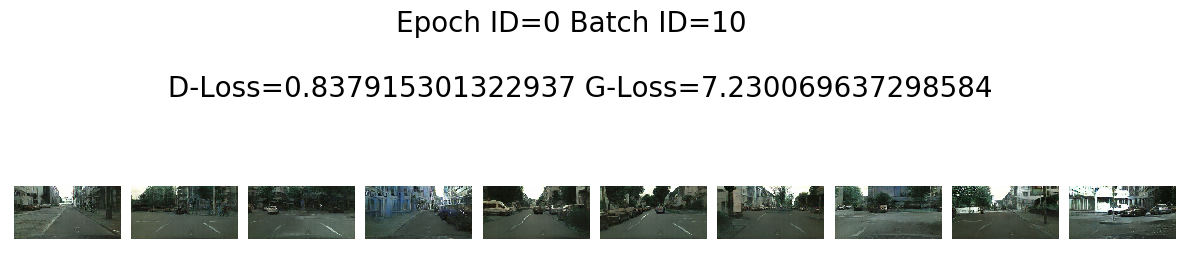

In [11]:
# create Net
netG = UnetGenerator()
netD = NLayerDiscriminator()

# 如果想要接着之前训练的模型训练，将if 0修改为if 1即可
if 1:
    try:
        mydict = paddle.load('generator.params')
        netG.set_dict(mydict)
        mydict = paddle.load('discriminator.params')
        netD.set_dict(mydict)
    except:
        print('fail to load model')

netG.train()
netD.train()

optimizerD = paddle.optimizer.Adam(parameters=netD.parameters(), learning_rate=0.0002, beta1=0.5, beta2=0.999)
optimizerG = paddle.optimizer.Adam(parameters=netG.parameters(), learning_rate=0.0002, beta1=0.5, beta2=0.999)

bce_loss = paddle.nn.BCELoss()
l1_loss = paddle.nn.L1Loss()

# 最大迭代epoch
max_epoch = 50

now_step = 0
for epoch in range(max_epoch):
    for step, (img, mask) in enumerate(dataloader):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        # 清除D的梯度
        optimizerD.clear_grad()

        # 传入正样本，并更新梯度
        pos_img = paddle.concat((img, mask), 1)
        # label = paddle.full([pos_img.shape[0], 1], 1, dtype='float32')
        pre = netD(pos_img)
        loss_D_1 = bce_loss(pre, paddle.ones_like(pre))
        loss_D_1.backward()

        # 通过randn构造随机数，制造负样本，并传入D，更新梯度
        fake_img = netG(mask).detach()
        neg_img = paddle.concat((fake_img, mask), 1)
        # label = paddle.full([pos_img.shape[0], 1], 0, dtype='float32')
        pre = netD(neg_img.detach()) # 通过detach截断网络梯度，不影响G的梯度计算
        loss_D_2 = bce_loss(pre, paddle.zeros_like(pre))
        loss_D_2.backward()

        # 更新D网络参数
        optimizerD.step()
        optimizerD.clear_grad()

        loss_D = loss_D_1 + loss_D_2

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################

        # 清除D的梯度
        optimizerG.clear_grad()

        fake_img = netG(mask)
        fake = paddle.concat((fake_img, mask), 1)
        # label = paddle.full((pos_img.shape[0], 1), 1, dtype=np.float32,)
        output = netD(fake)
        loss_G_1 = l1_loss(fake_img, img) * 100.
        loss_G_2 = bce_loss(output, paddle.ones_like(pre))
        loss_G = loss_G_1+loss_G_2
        loss_G.backward()

        # 更新G网络参数
        optimizerG.step()
        optimizerG.clear_grad()

        now_step += 1

        print('\r now_step is:', now_step,end = '')
        ###########################
        # 可视化
        ###########################
        if now_step % 100 == 0:
            print()
            plt.figure(figsize=(15,15))
            try:
                for i in range(10):
                    # image = generated_image[i].transpose()
                    image = fake_img[i]
                    image = np.where(image > 0, image, 0)
                    image = image.transpose((1,2,0))
                    plt.subplot(10, 10, i + 1)
                    
                    plt.imshow(image)
                    plt.axis('off')
                    plt.xticks([])
                    plt.yticks([])
                    plt.subplots_adjust(wspace=0.1, hspace=0.1)
                msg = 'Epoch ID={0} Batch ID={1} \n\n D-Loss={2} G-Loss={3}'.format(epoch, now_step, loss_D.numpy()[0], loss_G.numpy()[0])
                print(msg)
                plt.suptitle(msg,fontsize=20)
                plt.draw()
                # 保存在work文件夹下
                plt.savefig('{}/{:04d}_{:04d}.png'.format('work', epoch, now_step), bbox_inches='tight')
                plt.pause(0.01)
                break
            except IOError:
                print(IOError)
paddle.save(netG.state_dict(), "generator.params")
paddle.save(netD.state_dict(), "discriminator.params")

## 6. 模型预测
通过下述代码即可调用刚刚训练好的生成器啦~

True

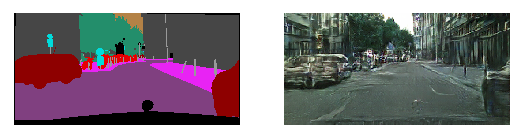

In [10]:
# 读取模型
netG = UnetGenerator()
mydict = paddle.load('generator.params')
netG.set_dict(mydict)
netG.eval()

# 读取分割图片
mask = cv2.imread('test.png')
h, w, c = mask.shape

# 绘制
plt.subplot(1, 2, 1)
plt.imshow(mask)
plt.axis('off')
plt.xticks([])
plt.yticks([])

# 预处理
mask = cv2.resize(mask, (512, 256)) # （宽，高）
mask = mask/255
mask = mask.transpose([2,0,1])
mask = paddle.to_tensor(mask).astype('float32')
mask = mask.reshape([1]+mask.shape)

# 将推理结果转化为图片
img = netG(mask)
img = img.numpy()[0]
img[img<0] = 0
img = (img*255).astype('uint8')
img = img.transpose((1,2,0))

# 绘制
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.axis('off')
plt.xticks([])
plt.yticks([])

# 保存
cv2.imwrite('result.jpg',img)

img = cv2.resize(img, (w, h)) # （宽，高）
cv2.imwrite('result_samesize.jpg',img)


## 7. 结语
本文简单的用全连接网络跑通了Pix2Pix的流程，如果对网络有更高的性能需求可以参考文首处的两个参考链接，内容类似，但是会更为详实。

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 